# *Group 39*: **Project Final Report**

In [1]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction:

Understanding the factors that influence how much time the player spends in a game is an important part of game design and player behavior research. Play time is often regarded as a measure of player engagement, learning progression, and overall satisfaction with the game. For Minecraft players, their characteristics, such as ages and previous gaming experience, will significantly shape how long individuals play and how quickly they learn game mechanics.

In this project, we try to answer the following research question:
Can a player's age and experience level be used to predict their total play time(played_hours)?
By analyzing the relationship between these variables, we hope to better understand which types of players tend to play for longer periods and whether experience level becomes a reliable indicator of engagement.

To investigate this question, we used the players.csv dataset, which contains information on 196 Minecraft players and seven variables: experience, subscribe, hashedEmail, name, gender, played_hours, and Age.
For our analysis, we chose the key variables that related to prediction: Experience, Age, and played_hours. The experience column contains five categories (Beginner, Regular, Amateur, Veteran, Pro), which we transfer into ordered numerical values to support statistical modeling. In the data-cleaning process, we identified and removed the missing values to ensure accurate analysis.
## Variables in players.csv

| Variable Name | Type        | Description |
|---------------|-------------|-------------|
| **experience** | Categorical | The player's experience level in the game (Beginner, Regular, Amateur, Veteran, Pro). |
| **subscribe**  | Logical     | Whether the player subscribed to the Minecraft-related newsletter. |
| **hashedEmail**| Feature     | A unique hashed identifier for each player. |
| **played_hours** | Numeric  | Total hours the player has spent playing the game. |
| **name**        | Feature    | The in-game avatar name of the player. |
| **gender**      | Feature    | The player’s reported gender. |
| **Age**         | Numeric    | The player’s age. |


Based on our work with the cleaned dataset and exploring patterns, ages, and total play time, we have laid the groundwork for subsequent use of methods such as K-Nearest Neighbor(KNN) regression to evaluate whether these features can effectively predict game duration.

In [2]:
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


# Methods and Results:

**Proposed Method**: Using knn regression to predict the played_hours for each player given the data from the experience and age columns

Next, we need to wrangle our data. Since `experience`, `played_hours`, and `Age`, are the only required columns for the analysis, we begin by selecting the required columns and ignoring the rest of the columns.

In [3]:
players_select <- players |> select(experience,played_hours,Age)
players_select

experience,played_hours,Age
<chr>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
⋮,⋮,⋮
Amateur,0.0,57
Amateur,2.3,17
Pro,0.2,NA


The next step of wrangling, involves converting the experience column from character column into a numerical column since knn regression requires all predictors to be numerical. This begins by first identifying all the unique experience levels in `experience` column and ensure that there no **NA** rows.

In [4]:
unique(players_select$experience)
any(is.na(players_select$experience))

[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

[1] FALSE

There are 5 experience levels in `experience` column and all rows contain an experience level: Pro, Veteran, Amateur, Regular and Beginner. A few searches in gaming forums show the order of these ranks: Beginner < Regular < Amateur < Veteran < Pro  
We can use this information and assign a unique numerical value for each rank.  
`Beginner` = 1  
`Regular`  = 2  
`Amateur`  = 3  
`Veteran`  = 4  
`Pro`      = 5

In [5]:
players_mutate <- players_select |>
            mutate(experience_num = case_when(
                experience == "Beginner" ~ 1,
                experience == "Regular" ~ 2,
                experience == "Amateur" ~ 3,
                experience == "Veteran" ~ 4,
                experience == "Pro" ~ 5))
players_mutate

experience,played_hours,Age,experience_num
<chr>,<dbl>,<dbl>,<dbl>
Pro,30.3,9,5
Veteran,3.8,17,4
Veteran,0.0,17,4
⋮,⋮,⋮,⋮
Amateur,0.0,57,3
Amateur,2.3,17,3
Pro,0.2,NA,5


With all the experience levels converted into numerical value and added to a new column, `experience` can be dropped from our dataframe.

In [6]:
players_mutate <- players_mutate |> select(-experience)
players_mutate

played_hours,Age,experience_num
<dbl>,<dbl>,<dbl>
30.3,9,5
3.8,17,4
0.0,17,4
⋮,⋮,⋮
0.0,57,3
2.3,17,3
0.2,NA,5


After successfully wrangling the data, we can perfom a summary of all the relevant columns that are relavant to our data analysis and add the mean values to a dataframe.

In [7]:
summary(players_mutate)

players_mean_table <- players_mutate |> summarize(play_hours_mean = round(mean(played_hours), 2), 
                                                  age_mean = round(mean(Age,na.rm= TRUE), 2), 
                                                  experience_mean = round(mean(experience_num),2))
players_mean_table

  played_hours          Age        experience_num 
 Min.   :  0.000   Min.   : 9.00   Min.   :1.000  
 1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:2.000  
 Median :  0.100   Median :19.00   Median :3.000  
 Mean   :  5.846   Mean   :21.14   Mean   :2.847  
 3rd Qu.:  0.600   3rd Qu.:22.75   3rd Qu.:4.000  
 Max.   :223.100   Max.   :58.00   Max.   :5.000  
                   NA's   :2                      

play_hours_mean,age_mean,experience_mean
<dbl>,<dbl>,<dbl>
5.85,21.14,2.85


Next we proccedd by analyzing the relationship between the predictors `experience`, `Age`, and response valraible `played_hours`.

We begin by looking at the relationship between `played_hours` and `Age`. (For this example, we use the players dataframe since our experience column is character making it easier to differentiate between each experience rank)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


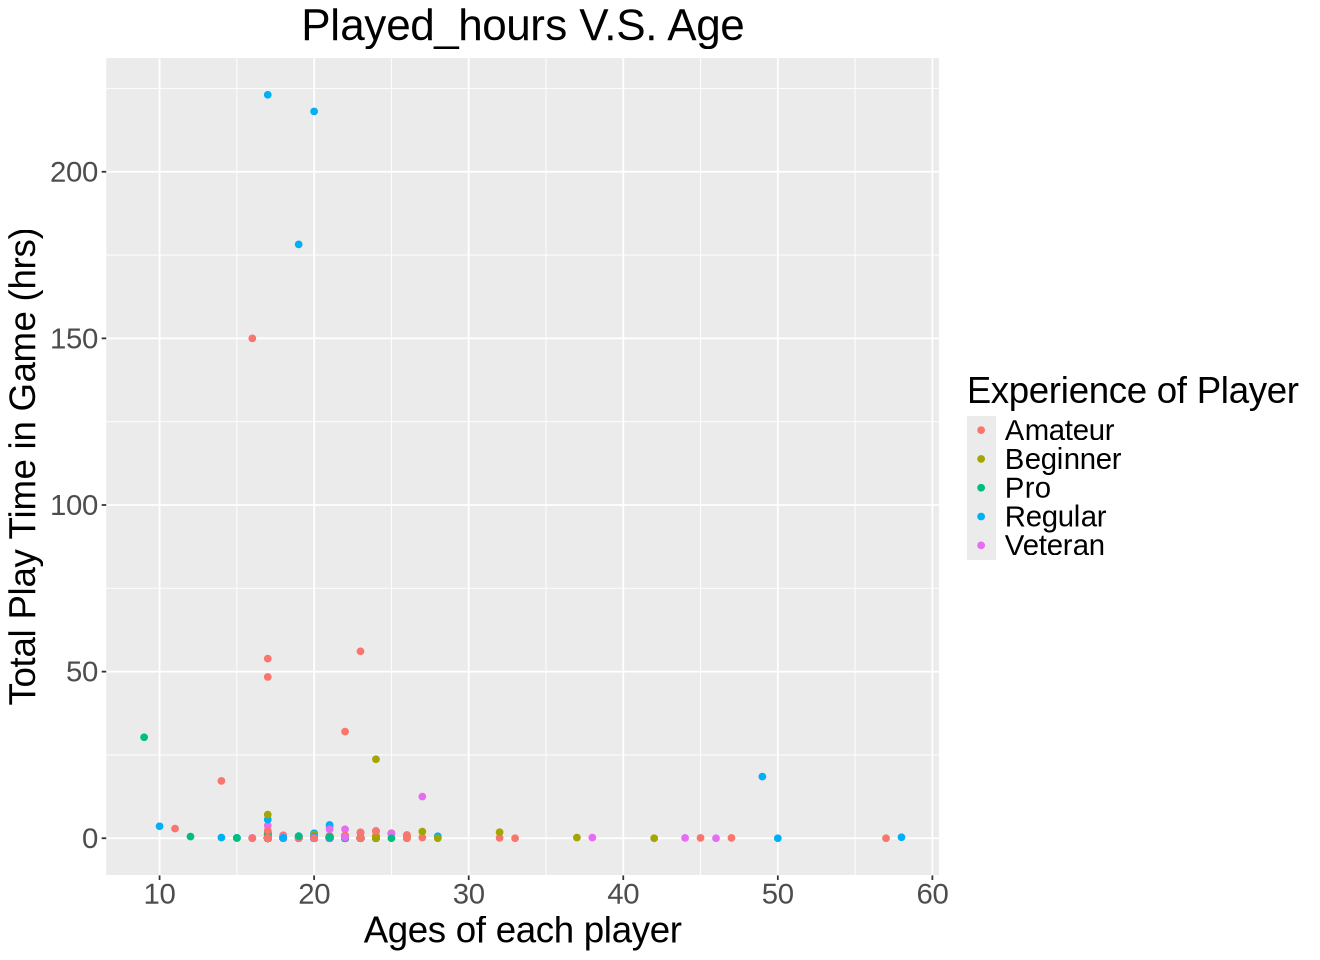

In [8]:
options(repr.plot.width = 11, repr.plot.height = 8)
hours_experience_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = experience)) +
    geom_point() +
    labs(
        x = "Ages of each player",
        y = "Total Play Time in Game (hrs)",
        color = "Experience of Player",
        title = "Played_hours V.S. Age") +
    theme(text = element_text(size = 22),
         plot.title = element_text(hjust = 0.5))
hours_experience_plot

Next we look at the Average played hours between each expereince rank. This involves by grouping all the `expreince` rows together and find the average played between them.

experience,avg_played_hours
<fct>,<dbl>
Veteran,0.6479167
Beginner,1.2485714
Pro,2.6000000
Amateur,6.0174603
Regular,18.2083333


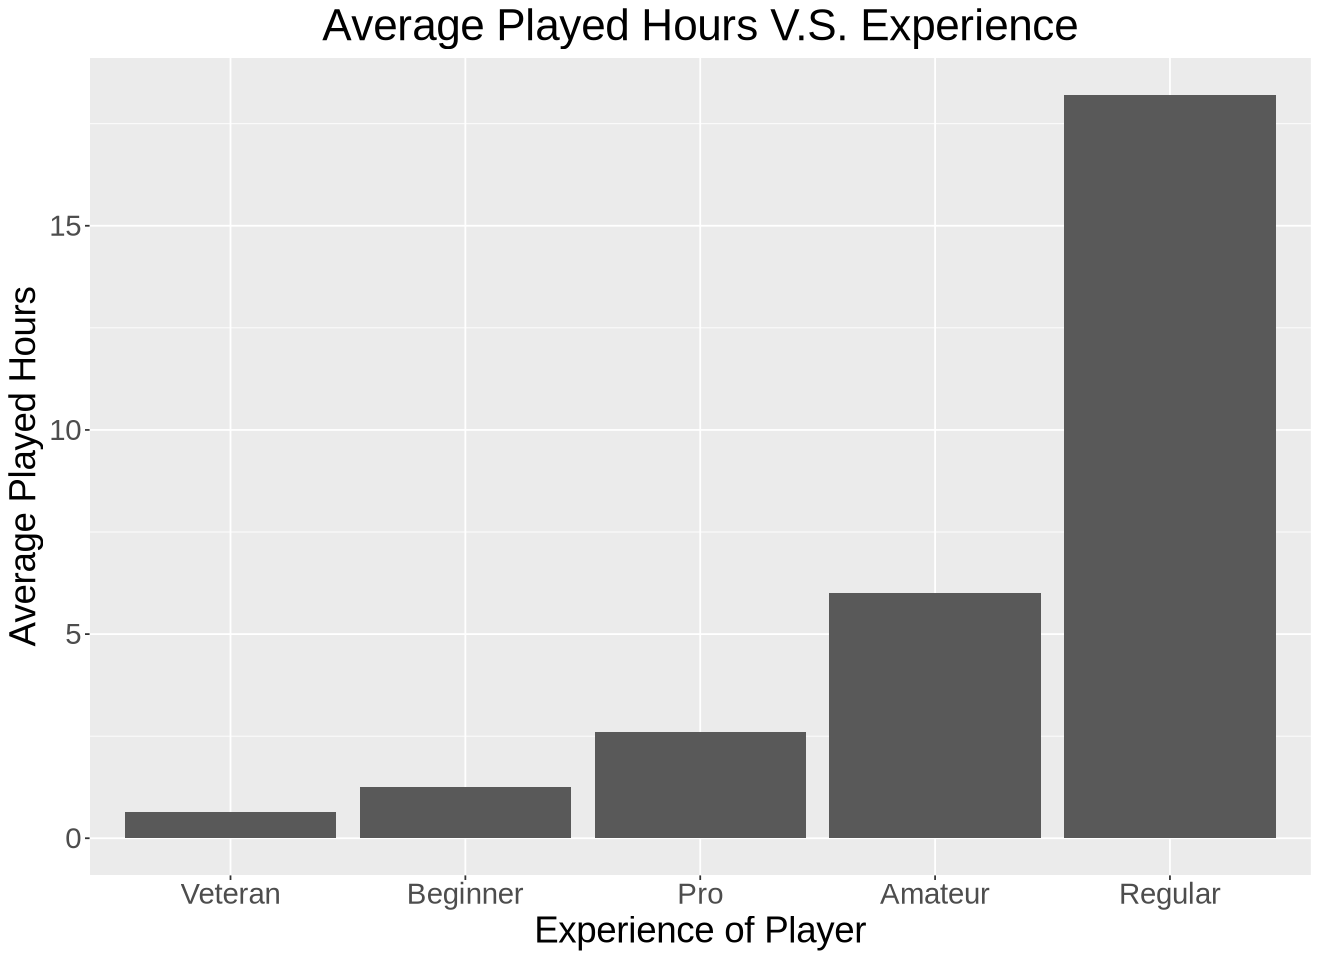

In [9]:
avg_played_hours <- players_mutate |> select(experience_num, played_hours) |> group_by(experience_num) |>
                    summarize(avg_played_hours = mean(played_hours)) |>
                    mutate(experience = case_when(
                experience_num == 1 ~ "Beginner",
                experience_num == 2 ~ "Regular",
                experience_num == 3 ~ "Amateur",
                experience_num == 4 ~ "Veteran",
                experience_num == 5 ~ "Pro")) |>
                relocate(experience) |> select(-experience_num) |> arrange(avg_played_hours) |>
                mutate(experience = fct_inorder(experience)) #Function used to allow R to plot from top to bottom (sorted)
                                                             #instead of alphabetic order
avg_played_hours

avg_hours_exp_plot <- avg_played_hours |>
                        ggplot(aes(x=experience, y = avg_played_hours))+
                        geom_bar(stat = "identity") +
                        labs(
                            x = "Experience of Player",
                            y = "Average Played Hours",
                            title = "Average Played Hours V.S. Experience") +
                        theme(text = element_text(size = 22),
                             plot.title = element_text(hjust = 0.5))
avg_hours_exp_plot

**Insights from the plots:** From the scatter plot, people in the ages 15-25 have more play time then the other groups which could mean that they have more time/bigger interest playing games. From the bar graph, people in the regular experience groups had highest avergae play time followed by amateur experience groups which could be because it can take newer players more time to get used to the game mechanics and regular players are more casual with their play style compared to veteran players who already know how to play really well and know all of the mechnanics.

# Discussion:

# References: